# NOTE THAT NO Augmentation

### 1) Sample form Data , saved on "Sampled_images"

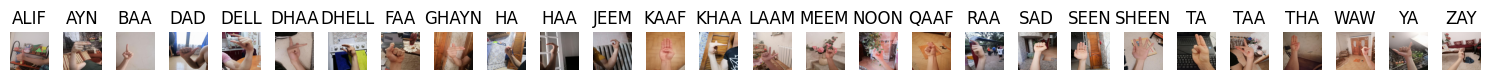

In [17]:
import os
import random
import shutil
import cv2
import matplotlib.pyplot as plt

sampled_dir = "Sampled_images"
os.makedirs(sampled_dir, exist_ok=True)

BASE_DIR = os.getcwd()
train_dir = os.path.join(BASE_DIR, "..", "data", "structured", "train_structured")
train_dir = os.path.abspath(train_dir)

classes = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]
if not classes:
    raise FileNotFoundError(f"No class folders found inside '{train_dir}'")

selected_images = []

plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(train_dir, class_name)
    all_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_files:
        print(f"No images in class {class_name}")
        continue
    
    img_name = random.choice(all_files)
    img_path = os.path.join(class_folder, img_name)
    selected_images.append(img_path)

    class_sampled_folder = os.path.join(sampled_dir, class_name)
    os.makedirs(class_sampled_folder, exist_ok=True)

    save_path = os.path.join(class_sampled_folder, img_name)
    shutil.copy(img_path, save_path)

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, len(classes), idx+1)
    plt.imshow(img_rgb)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


### 2) preprocess_hand_flat_bg_morph

[Skin mask , Gaussian blur , Adjust contrast & brightness , Unified background , Grayscale + Sobel edges]

In [6]:
import cv2
import numpy as np

def preprocess_hand_flat_bg_morph(image_path, blur_ksize=5, alpha=1.3, beta=20, bg_color=(0,0,0), morph_ksize=5):
    """
    - Skin detection (YCbCr)
    - Morphological open & close to clean mask
    - Gaussian blur
    - Contrast & brightness
    - Unified background
    - Sobel edges
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Skin mask
    img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    mask = cv2.inRange(img_ycrcb, (0, 133, 77), (255, 173, 127))

    # Morphology: remove small dots (opening) & fill small holes (closing)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ksize, morph_ksize))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # Apply mask
    skin = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_clean)

    # Gaussian blur + contrast/brightness
    skin = cv2.GaussianBlur(skin, (blur_ksize, blur_ksize), 0)
    skin = cv2.convertScaleAbs(skin, alpha=alpha, beta=beta)

    # Unified background
    bg = np.full_like(img_rgb, bg_color)
    mask_3ch = cv2.merge([mask_clean, mask_clean, mask_clean])
    hand_only = np.where(mask_3ch>0, skin, bg)

    # Sobel edges
    gray = cv2.cvtColor(hand_only, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)
    sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))
    _, edges = cv2.threshold(sobel_mag, 50, 255, cv2.THRESH_BINARY)

    return hand_only, edges

### 3) preprocess_hand_flat_bg_morph_v2

Skin Mask
Detects skin regions to accurately isolate the hand from the background.
Enhances hand segmentation and reduces noise.

Gaussian Blur
Smooths the hand region to remove minor noise and irregularities.
Improves clarity and consistency of the hand shape.

Adjust Contrast & Brightness
Boosts contrast and brightness of the hand area.
Enhances visibility of hand features and fine details.

Unified Background
Converts the background to a consistent black while keeping the hand intact.
Removes distractions and emphasizes the hand region.

Grayscale + Sobel Edges
Converts the hand image to grayscale and extracts edges using Sobel (and optionally Canny).
Produces sharp and clean edge maps ready for machine learning or further processing.

In [1]:
import cv2
import numpy as np

def preprocess_hand_flat_bg_morph_v2(
        image_path, 
        blur_ksize=5, 
        alpha=1.25, 
        beta=15, 
        bg_color=(0, 0, 0), 
        morph_ksize=7,
        canny_low=40,
        canny_high=120
    ):
    """
    Improvements:
    - More precise skin mask using YCrCb with tightened ranges
    - Reduce noise before and after mask
    - Fully black background
    - Sobel + Canny hybrid for cleaner edge detection
    """

    # ----------------------
    # 1) Load image
    # ----------------------
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ----------------------
    # 2) Strong smoothing before mask
    # ----------------------
    # Helps make skin detection stable and avoid background noise
    smooth = cv2.bilateralFilter(img, 9, 75, 75)

    # ----------------------
    # 3) Skin mask using YCrCb
    # ----------------------
    ycrcb = cv2.cvtColor(smooth, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    # tightened skin ranges for more accuracy
    mask = cv2.inRange(
        ycrcb,
        (20, 135, 85),   # lower bound
        (240, 170, 135)  # upper bound
    )

    # ----------------------
    # 4) Morphology clean-up
    # ----------------------
    # Larger kernel to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ksize, morph_ksize))

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # ----------------------
    # 5) Extract hand only
    # ----------------------
    hand_only = cv2.bitwise_and(smooth, smooth, mask=mask)

    # ----------------------
    # 6) Boost contrast and brightness
    # ----------------------
    hand_only = cv2.GaussianBlur(hand_only, (blur_ksize, blur_ksize), 0)
    hand_only = cv2.convertScaleAbs(hand_only, alpha=alpha, beta=beta)

    # ----------------------
    # 7) Unified pure black background
    # ----------------------
    bg = np.full_like(hand_only, bg_color)
    mask3 = cv2.merge([mask, mask, mask])
    hand_clean = np.where(mask3 > 0, hand_only, bg)

    # ----------------------
    # 8) Edge detection: Sobel + Canny Hybrid
    # ----------------------
    gray = cv2.cvtColor(hand_clean, cv2.COLOR_RGB2GRAY)

    # Compute Sobel magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)

    sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))
    sobel_mag = cv2.GaussianBlur(sobel_mag, (3, 3), 0)

    # Apply Canny on Sobel output for cleaner edges
    edges = cv2.Canny(sobel_mag, canny_low, canny_high)

    # Optionally make edges thicker for ML clarity
    edges = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)

    return hand_clean, edges

### 4) Observations

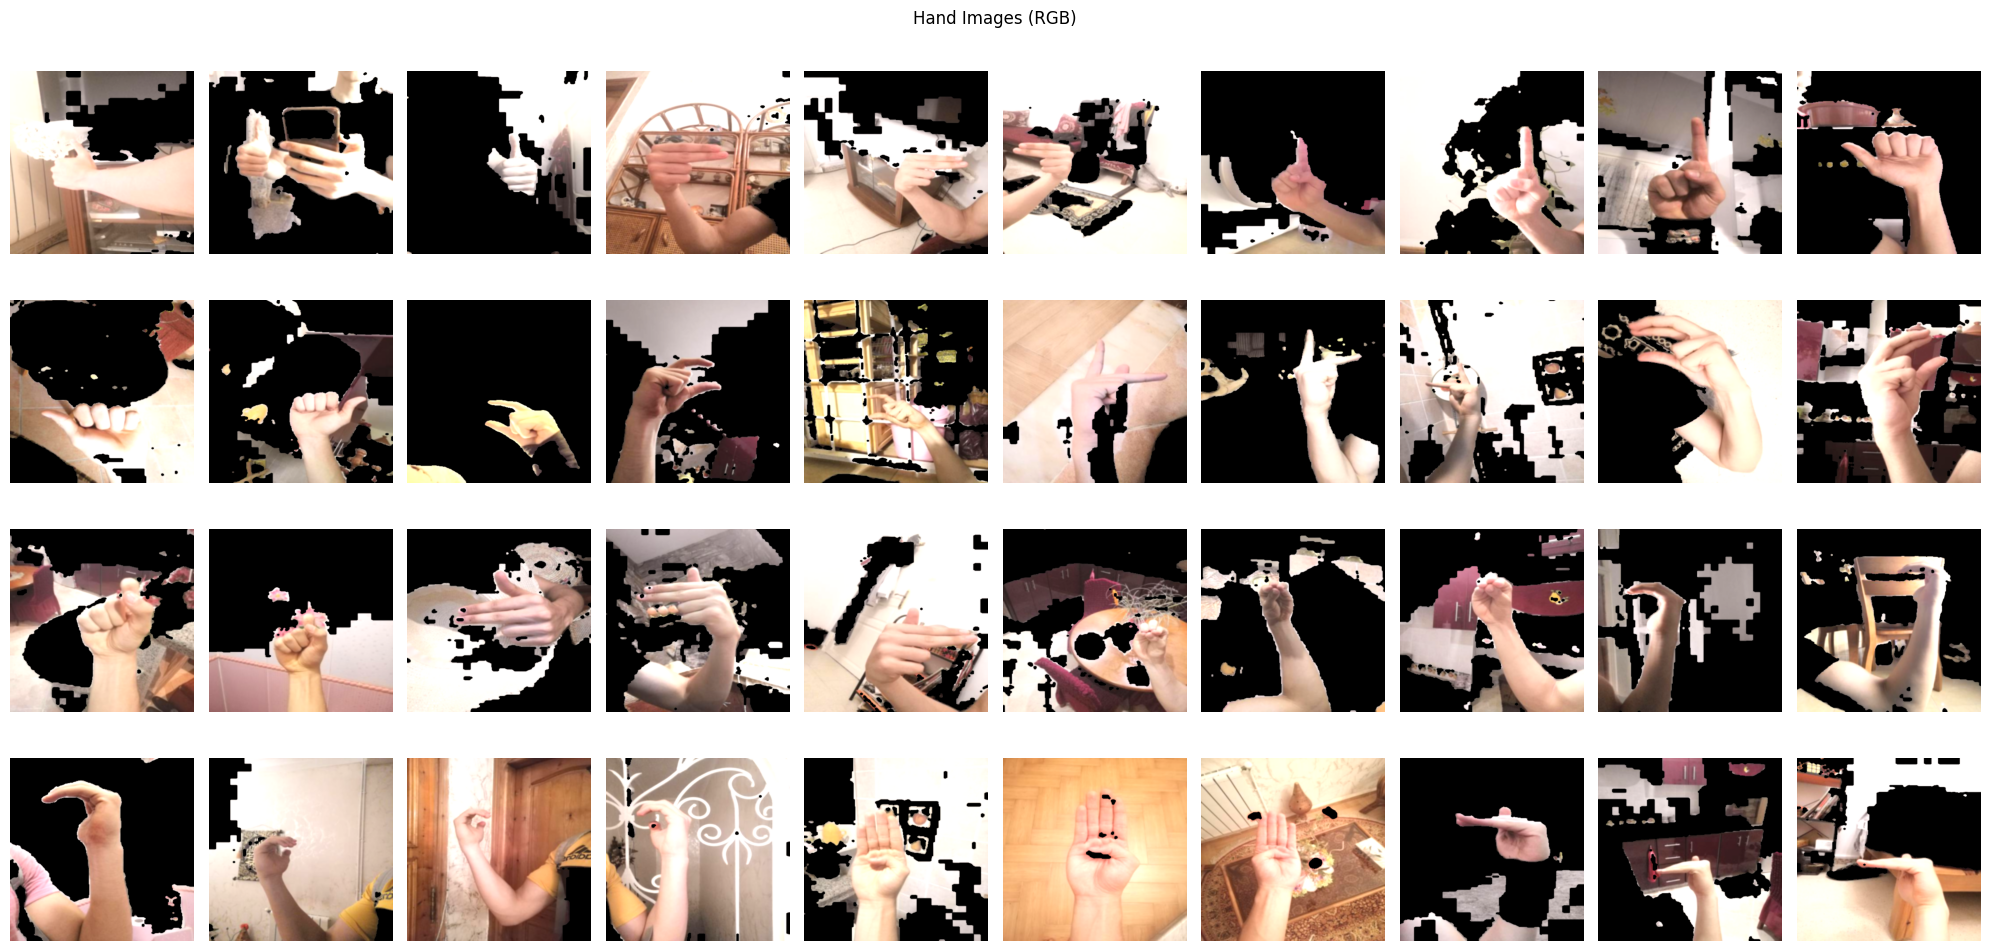

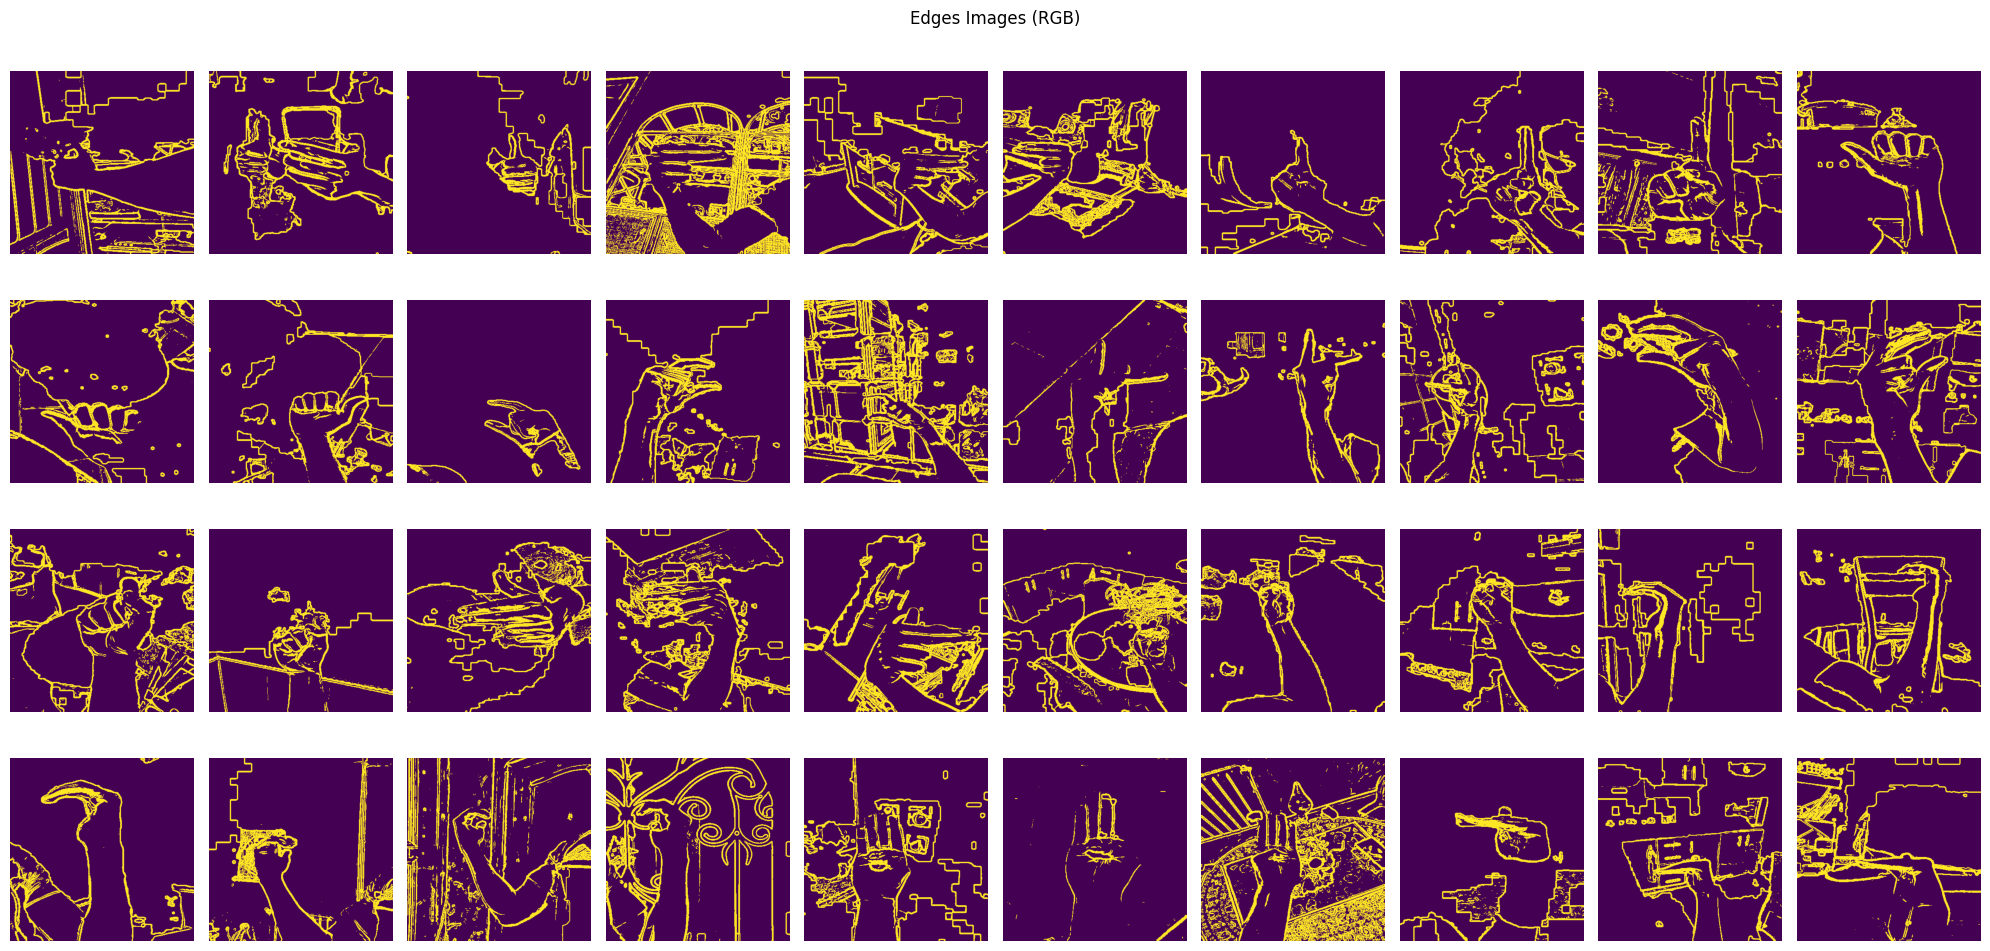

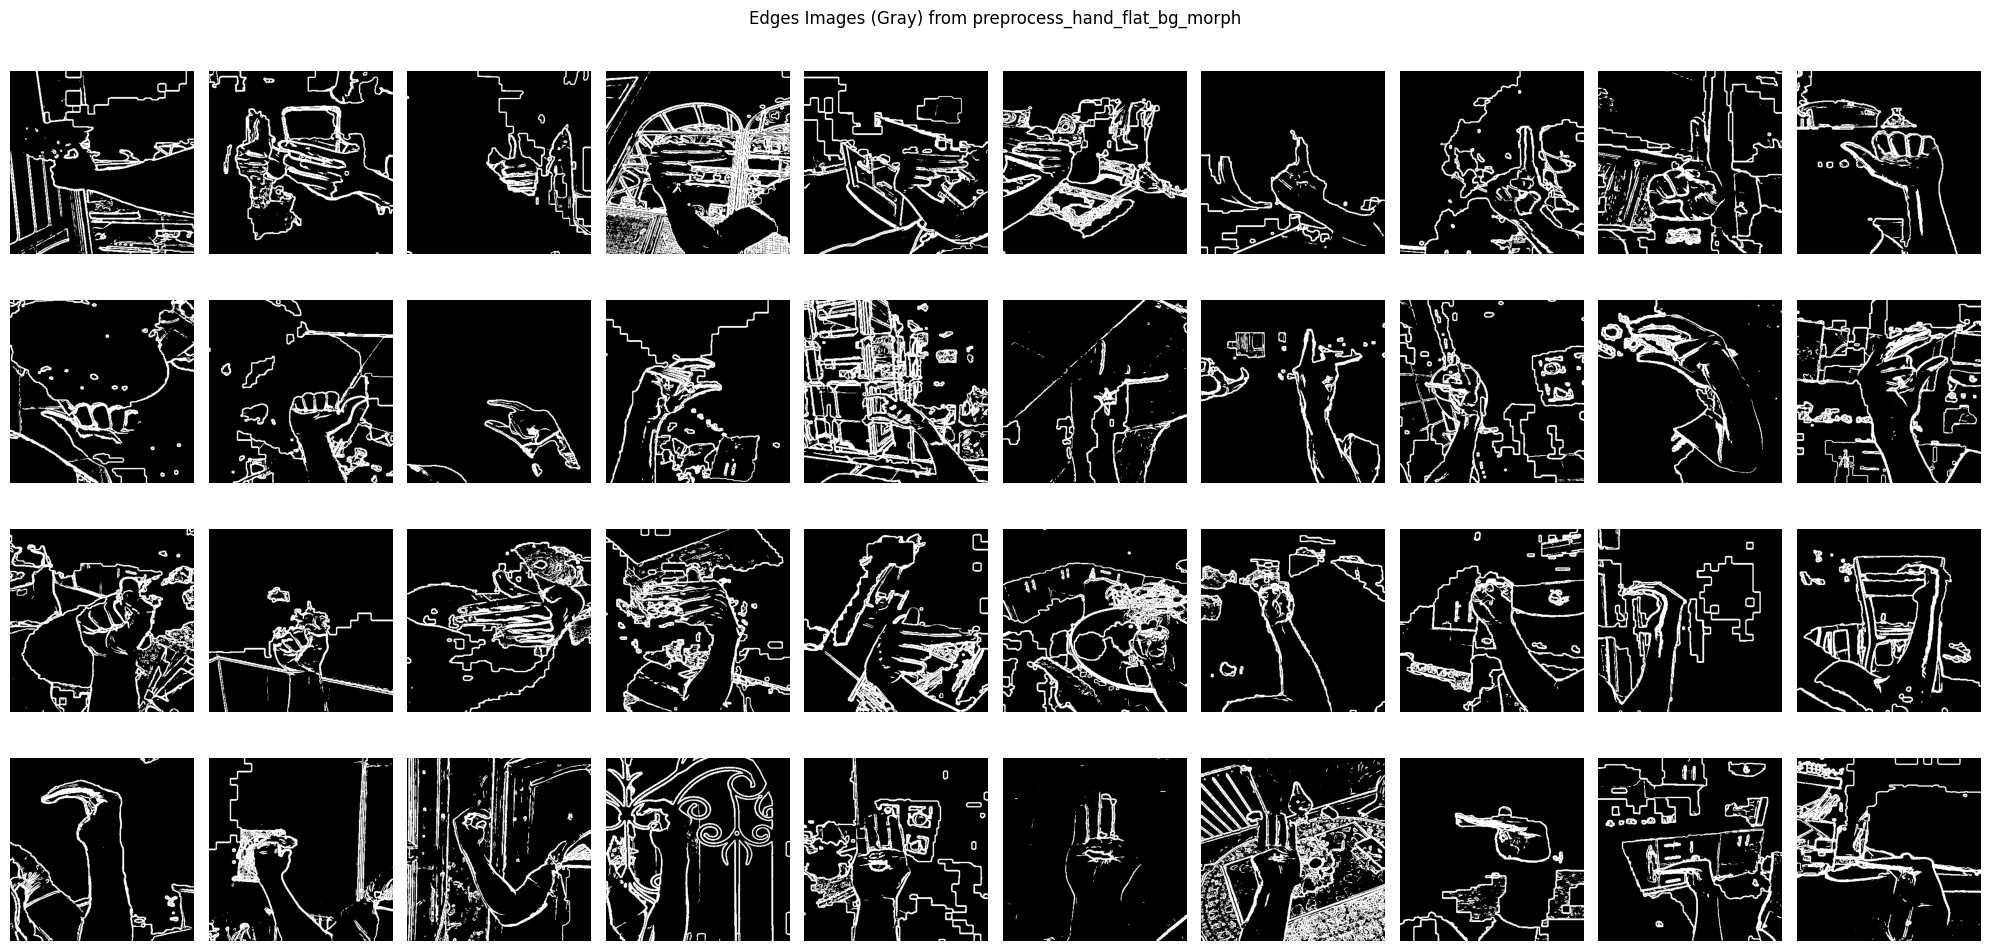

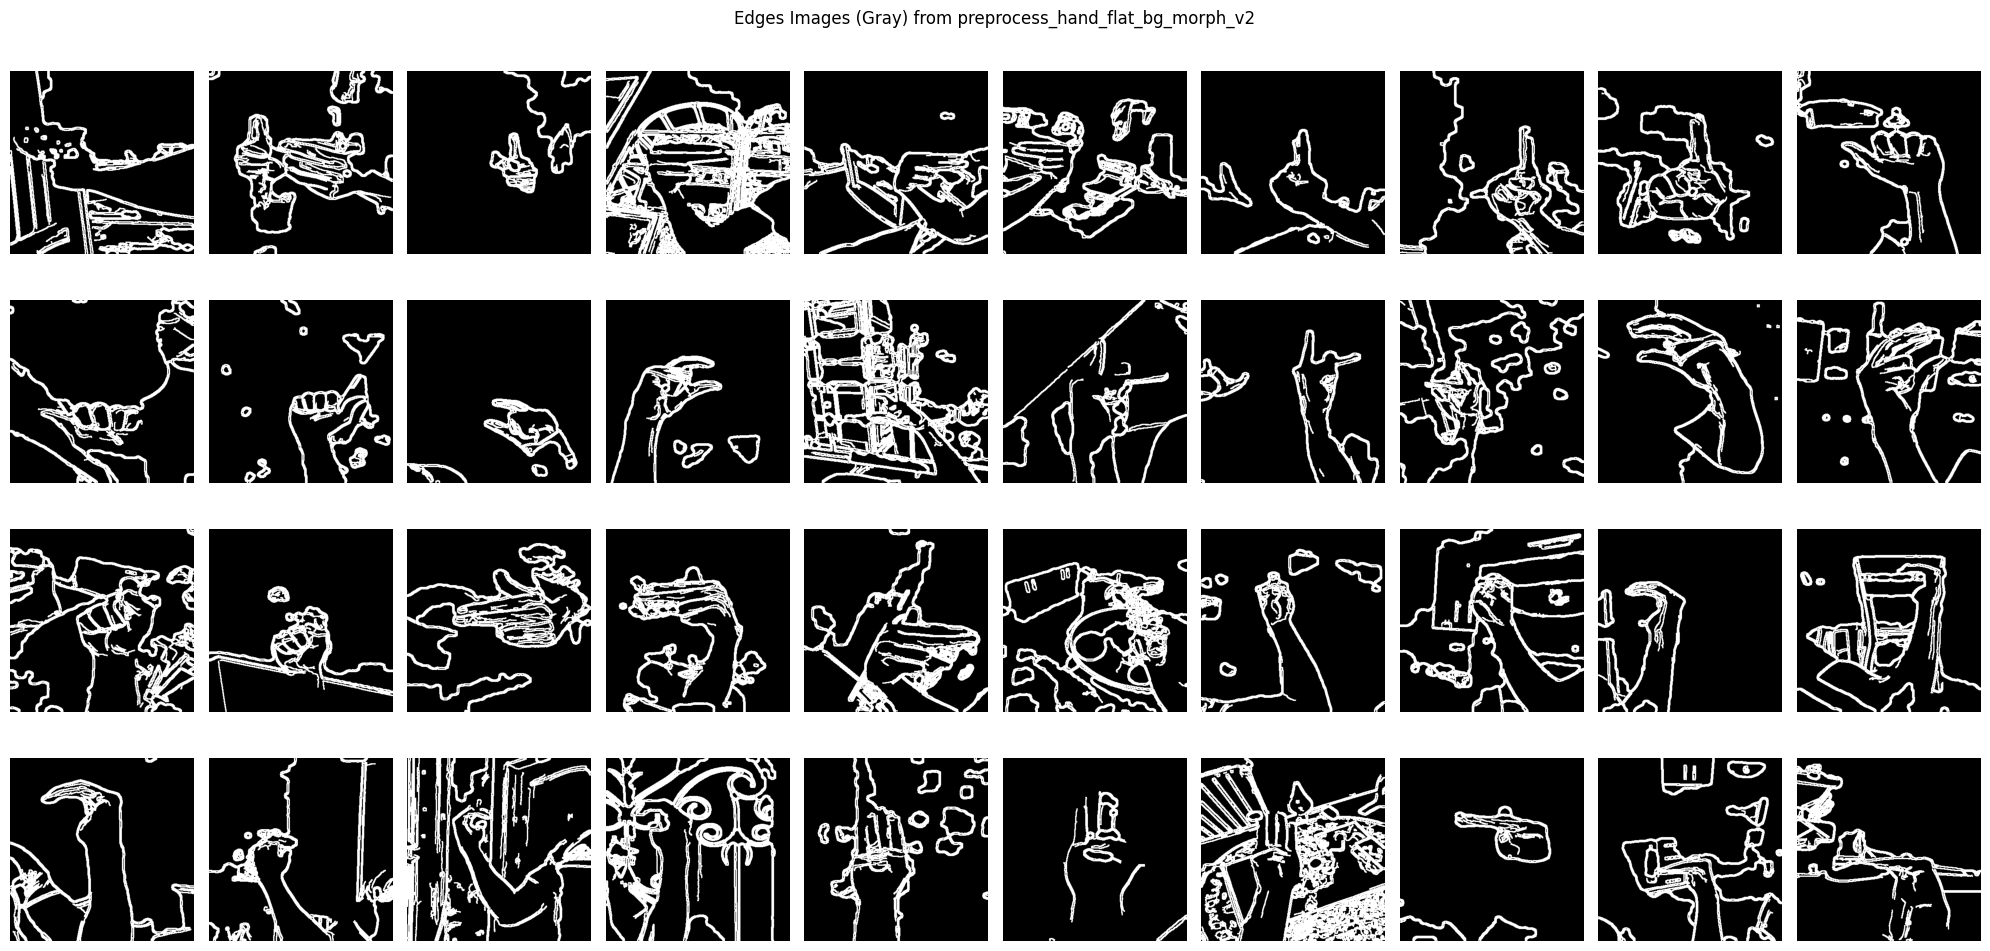

In [14]:
import os
import matplotlib.pyplot as plt

# -------------------------
# Settings
# -------------------------
num_to_show = 40
sample_dir = "Sampled_images"
folders = [f for f in os.listdir(sample_dir) if os.path.isdir(os.path.join(sample_dir, f))]

# Save directories
save_dir = "edge_images"
os.makedirs(save_dir, exist_ok=True)

# -------------------------
# 1) Process all images once
# -------------------------
hand_images_rgb = []
edges_images_rgb = []
edges_images_gray = []
edges_v2_gray = []
class_names_list = []

shown_count = 0
for folder_name in folders:
    img_dir = os.path.join(sample_dir, folder_name)
    all_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    for img_name in all_files:
        if shown_count >= num_to_show:
            break
        img_path = os.path.join(img_dir, img_name)
        try:
            # --------------------------
            # preprocess_hand_flat_bg_morph
            # --------------------------
            hand_img, edges_img = preprocess_hand_flat_bg_morph(img_path)
            hand_images_rgb.append(hand_img)
            edges_images_rgb.append(edges_img)
            edges_images_gray.append(edges_img)  # for gray display later

            # --------------------------
            # preprocess_hand_flat_bg_morph_v2 (edges only gray)
            # --------------------------
            _, edges_img_v2 = preprocess_hand_flat_bg_morph_v2(img_path)
            edges_v2_gray.append(edges_img_v2)

            class_names_list.append(folder_name)

            # --- Save edges_v2_gray for example ---
            class_save_dir = os.path.join(save_dir, folder_name)
            os.makedirs(class_save_dir, exist_ok=True)
            save_path = os.path.join(class_save_dir, f"output_{shown_count+1:02d}.png")
            plt.imsave(save_path, edges_img_v2, cmap='gray')

            shown_count += 1
        except FileNotFoundError:
            continue
    if shown_count >= num_to_show:
        break

# -------------------------
# 2) Display hand images (RGB)
# -------------------------
plt.figure(figsize=(20, 10))
for idx, img in enumerate(hand_images_rgb):
    plt.subplot(4, 10, idx+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Hand Images (RGB)")
plt.tight_layout()
plt.show()

# -------------------------
# 3) Display edges images (RGB)
# -------------------------
plt.figure(figsize=(20, 10))
for idx, img in enumerate(edges_images_rgb):
    plt.subplot(4, 10, idx+1)
    plt.imshow(img)  # RGB, appears grayscale
    plt.axis('off')
plt.suptitle("Edges Images (RGB)")
plt.tight_layout()
plt.show()

# -------------------------
# 4) Display edges images (Gray)
# -------------------------
plt.figure(figsize=(20, 10))
for idx, img in enumerate(edges_images_gray):
    plt.subplot(4, 10, idx+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Edges Images (Gray) from preprocess_hand_flat_bg_morph")
plt.tight_layout()
plt.show()

# -------------------------
# 5) Display edges images (Gray) v2
# -------------------------
plt.figure(figsize=(20, 10))
for idx, img in enumerate(edges_v2_gray):
    plt.subplot(4, 10, idx+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Edges Images (Gray) from preprocess_hand_flat_bg_morph_v2")
plt.tight_layout()
plt.show()


### 5) Save imgs

In [ ]:
# import os
# import cv2

# --------------------------------
# Paths
# --------------------------------

# BASE_DIR = os.getcwd()

# DATA_DIRS = {
#     "train": os.path.join(BASE_DIR, "..", "data", "structured", "train_structured"),
#     "valid": os.path.join(BASE_DIR, "..", "data", "structured", "valid_structured")
# }

# OUTPUT_DIR = os.path.join(
#     BASE_DIR, "..", "data", "pre-processed", "First_Preprocessed_Data_imgs"
# )

# PREPROCESS_DIR = os.path.join(OUTPUT_DIR, "preprocess_hand")
# EDGES_DIR = os.path.join(OUTPUT_DIR, "edges_only")

# os.makedirs(PREPROCESS_DIR, exist_ok=True)
# os.makedirs(EDGES_DIR, exist_ok=True)

# --------------------------------
# Process all images
# --------------------------------

# for split, base_path in DATA_DIRS.items():
#     if not os.path.exists(base_path):
#         print(f"Folder not found: {base_path}")
#         continue

#     classes = [
#         f for f in os.listdir(base_path)
#         if os.path.isdir(os.path.join(base_path, f))
#     ]

#     for class_name in classes:
#         class_path = os.path.join(base_path, class_name)

#         all_files = [
#             f for f in os.listdir(class_path)
#             if f.lower().endswith((".png", ".jpg", ".jpeg"))
#         ]

#         for img_name in all_files:
#             img_path = os.path.join(class_path, img_name)

#             try:
#                 # ----------------------
#                 # Apply preprocess_hand_flat_bg_morph_v2
#                 # ----------------------
#                 hand_clean, edges_img = preprocess_hand_flat_bg_morph_v2(img_path)

#                 # hand_clean
#                 class_pre_dir = os.path.join(PREPROCESS_DIR, split, class_name)
#                 os.makedirs(class_pre_dir, exist_ok=True)

#                 save_path_pre = os.path.join(class_pre_dir, img_name)
#                 cv2.imwrite(
#                     save_path_pre,
#                     cv2.cvtColor(hand_clean, cv2.COLOR_RGB2BGR)
#                 )

#                 # edges_img
#                 class_edges_dir = os.path.join(EDGES_DIR, split, class_name)
#                 os.makedirs(class_edges_dir, exist_ok=True)

#                 save_path_edges = os.path.join(class_edges_dir, img_name)
#                 cv2.imwrite(save_path_edges, edges_img)  # edges grayscale

#             except Exception as e:
#                 print(f"Error processing {img_path}: {e}")

# print("All images processed and saved in FINALL_PRE.")


Note that : 

edges only -> 270 mb

whole hand -> 150 mb

### 6) Convert imgs to Tensors

In [ ]:
# import os
# import cv2
# import torch
# import numpy as np

# def save_images_as_tensors(folder_path, output_dir, img_size=(416,416), dtype=torch.float32):
#     """
#     folder_path: folder containing subfolders for each class
#     output_dir: folder to save tensors for each image
#     img_size: target image size (H,W)
#     dtype: data type to reduce size (e.g., float16 or float32)
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Get class folder names
#     classes = [
#         f for f in os.listdir(folder_path)
#         if os.path.isdir(os.path.join(folder_path, f))
#     ]
#     classes.sort()

#     for class_name in classes:
#         class_path = os.path.join(folder_path, class_name)
#         out_class_dir = os.path.join(output_dir, class_name)
#         os.makedirs(out_class_dir, exist_ok=True)

#         # Get all image files
#         all_files = [
#             f for f in os.listdir(class_path)
#             if f.lower().endswith((".png", ".jpg", ".jpeg"))
#         ]

#         for img_name in all_files:
#             img_path = os.path.join(class_path, img_name)
            
#             # Read image as grayscale
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 continue
            
#             # Resize image
#             img = cv2.resize(img, img_size)
            
#             # Normalize to [0,1]
#             img = img.astype(np.float32) / 255.0
            
#             # Convert image to Tensor (1, H, W)
#             tensor = torch.tensor(img, dtype=dtype).unsqueeze(0)
            
#             # Save tensor as .pt file
#             save_path = os.path.join(
#                 out_class_dir,
#                 img_name.replace(".", "_") + ".pt"
#             )
#             torch.save(tensor, save_path)


# -------------------------------
# Paths
# -------------------------------

# BASE_DIR = os.getcwd()

# EDGE_DIR = os.path.join(
#     BASE_DIR,
#     "..",
#     "data",
#     "pre-processed",
#     "First_Preprocessed_Data_imgs",
#     "edges_only"
# )

# OUTPUT_DIR = os.path.join(
#     BASE_DIR,
#     "..",
#     "data",
#     "processed",
#     "1st_preprocessed_data_tensors_indiv_32"
# )

# os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------
# Process all images in train & valid and save as tensors
# -------------------------------

# for split in ["train", "valid"]:
#     folder_path = os.path.join(EDGE_DIR, split)
#     out_split_dir = os.path.join(OUTPUT_DIR, split)
#     os.makedirs(out_split_dir, exist_ok=True)

#     if not os.path.exists(folder_path):
#         print(f"Folder not found: {folder_path}")
#         continue

#     # Call function to save all images as tensors
#     save_images_as_tensors(
#         folder_path,
#         out_split_dir,
#         img_size=(416, 416),
#         dtype=torch.float32
#     )

#     print(f"{split} tensors saved in {out_split_dir}")


train tensors saved in e:\@Career\AI\Technology\College Use\fifth term\computer vision\Final_CV_project\ArSL_HandGestureNet\notebooks\..\data\processed\1st_preprocessed_data_tensors_indiv_32\train
valid tensors saved in e:\@Career\AI\Technology\College Use\fifth term\computer vision\Final_CV_project\ArSL_HandGestureNet\notebooks\..\data\processed\1st_preprocessed_data_tensors_indiv_32\valid


Note that : 

folat16 -> 1.8 GB 

folat32 -> 3.57 GB 